In [1]:
import sys
import os
import cv2
from PIL import Image as PIL_Image
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import random
import time
import glob

from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import multiprocessing
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.applications import mobilenet, imagenet_utils
from dl_postprocessing import plot_model_data

from IPython.display import clear_output, Image

# from dealing_with_images import move_files_randomly, delete_files_randomly, copy_resize_images
import pickle

def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return mobilenet.preprocess_input(img_array_expanded_dims)
def prepare_npArr(img_array):
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return mobilenet.preprocess_input(img_array_expanded_dims)

In [2]:
from sklearn.model_selection import KFold, StratifiedKFold

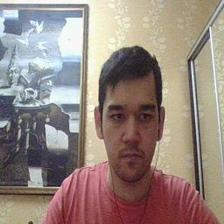

In [8]:
Image(filename='data/train_224/0/1.jpg')

In [2]:
model = models.load_model('MobileNet_1layerTrained.tf')

In [6]:
# predicting classification based on the imagenet trained model
preprocessed_image = prepare_image('data/train_224/0/1.jpg')
predictions = model.predict(preprocessed_image)
# results = imagenet_utils.decode_predictions(predictions)
predictions

array([[4.868455e-12]], dtype=float32)

In [7]:
# Training only the first layer from the front
base_model = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [3]:
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
train_datagen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)

validation_datagen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)

In [4]:
size = 224
train_generator = train_datagen.flow_from_directory('data/train_224',
    target_size=(size, size), batch_size=32, class_mode='binary')

validation_generator = validation_datagen.flow_from_directory('data/valid_224',
    target_size=(size, size), batch_size=32, class_mode='binary')

Found 4022 images belonging to 2 classes.
Found 1006 images belonging to 2 classes.


In [8]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
step_size = train_generator.n//train_generator.batch_size
step_size_valid = validation_generator.n//validation_generator.batch_size

with tf.device('/device:GPU:0'):
    history = model.fit_generator(train_generator, epochs=10, steps_per_epoch=step_size, 
                    validation_data=validation_generator,
                   validation_steps=step_size_valid,
                    callbacks=[early_stopping_monitor])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
125/125 [==============================] - 22s 132ms/step - loss: 0.0626 - accuracy: 0.9689 - val_loss: 0.0044 - val_accuracy: 0.9990
Epoch 2/10
125/125 [==============================] - 15s 122ms/step - loss: 0.0169 - accuracy: 0.9972 - val_loss: 0.0104 - val_accuracy: 0.9990


In [9]:
model.save('MobileNet_1layerTrained.tf', save_format='tf')

INFO:tensorflow:Assets written to: MobileNet_1layerTrained.tf/assets


In [10]:
with open('MobileNet_1layerTrained.p', 'wb') as f:
    pickle.dump(history.history, f)

In [21]:
# Training all layers but initial weights are imagenet
base_model = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-3]:
    layer.trainable = False
for layer in base_model.layers[-3:]:
    layer.trainable = True
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [18]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
step_size = train_generator.n//train_generator.batch_size
step_size_valid = validation_generator.n//validation_generator.batch_size

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator, epochs=10, steps_per_epoch=step_size, 
                    validation_data=validation_generator,
                   validation_steps=step_size_valid,
                    callbacks=[early_stopping_monitor])

Epoch 1/10
125/125 [==============================] - 80s 565ms/step - loss: 0.5482 - accuracy: 0.9032 - val_loss: 0.9184 - val_accuracy: 0.5000
Epoch 2/10
125/125 [==============================] - 75s 600ms/step - loss: 0.0490 - accuracy: 0.9868 - val_loss: 1.1427 - val_accuracy: 0.4990


In [ ]:
#Load the saved model
model = models.load_model('MobileNet_1layerTrained.tf')
video = cv2.VideoCapture(0)

while True:
    _, frame = video.read()
    RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    im = PIL_Image.fromarray(frame)
    im = im.resize((224, 224))
    img_array = np.array(im)
    img_array = prepare_npArr(img_array)
    prediction = model.predict(img_array)[0][0]
    prediction = int(model.predict(img_array))
    plt.imshow(RGB_img)
    plt.show()
    print(prediction)

    clear_output(wait=True)

video.release()
cv2.destroyAllWindows()

In [9]:
model.predict(img_array)[0][0]

0.9999782